In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
import numpy as np 
from tqdm.notebook import tqdm 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torch.optim.lr_scheduler as lr_scheduler

# Load

In [3]:
transforms_simple = T.Compose([
    T.ToTensor(), 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

In [4]:
mean = torch.zeros(3, dtype=float)
mean_sq = torch.zeros(3, dtype=float)
n = len(train_loader)

for x, _ in train_loader:
    mean += torch.mean(x, dim=(0, 2, 3))
    mean_sq += torch.mean(x ** 2, dim=(0, 2, 3))

mean /= n
mean_sq /= n
std = torch.sqrt(mean_sq - mean ** 2)

In [5]:
mean

tensor([0.4802, 0.4481, 0.3976], dtype=torch.float64)

In [6]:
std

tensor([0.2770, 0.2691, 0.2821], dtype=torch.float64)

In [7]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [8]:
num_classes = len(train_folder.class_to_idx)

# Model

In [9]:
model = torchvision.models.GoogLeNet()

/home/denis/miniconda3/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [10]:
# model.conv1 = nn.Conv2d(3, 192, kernel_size=7, stride=1, padding=0)
model.conv1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=5, stride=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=5, stride=1)
)
model.conv2 = nn.Identity()
model.conv3 = nn.Identity()
model.maxpool2 = nn.Identity()

# Train

In [11]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [12]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [13]:
iter1 = iter(train_loader)
iter2 = iter(train_loader)
x1, y1 = next(iter1)
x2, y2 = next(iter2)

In [14]:
class MixUp:
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, x1, x2):
        return x1 * self.alpha + x2 * (1 - self.alpha)

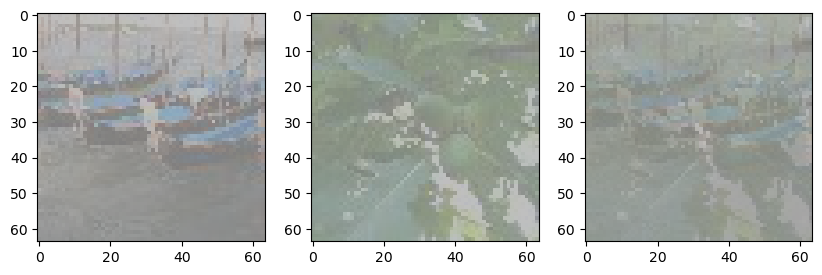

In [15]:
mixup = MixUp(0.5)
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(tensor_to_image(x1[1]))
axs[1].imshow(tensor_to_image(x2[1]))
axs[2].imshow(tensor_to_image(mixup(x1, x2)[1]))

In [16]:
from random import randint

In [17]:
class RandomCatOut:
    
    def __init__(self, size, prob):
        self.size = size
        self.prob = prob

    def __call__(self, sample):
        sample = sample.clone().detach()

        pos_x = randint(0, 64 - self.size)
        pos_y = randint(0, 64 - self.size)

        if np.random.binomial(n=1, p=self.prob, size=1)[0] == 1:
            sample[:, pos_x: pos_x + self.size, pos_y: pos_y + self.size] = 0

        return sample


In [18]:
class CutMix:
    def __init__(self, size):
        self.size = size

    def __call__(self, x1, x2):
        x1 = x1.clone()
        x2 = x2.clone()

        pos1_x = randint(0, 64 - self.size)
        pos1_y = randint(0, 64 - self.size)

        pos2_x = randint(0, 64 - self.size)
        pos2_y = randint(0, 64 - self.size)

        x1[:, :, pos1_x: pos1_x + self.size, pos1_y: pos1_y + self.size] = \
            x2[:, :, pos2_x: pos2_x + self.size, pos2_y: pos2_y + self.size]
        
        return x1

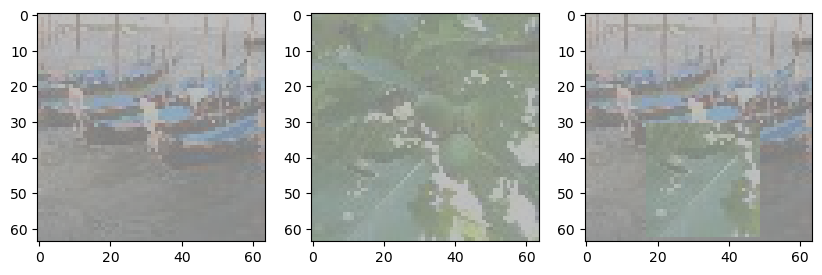

In [19]:
cutmix = CutMix(size=32)
x3 = cutmix(x1, x2)
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(tensor_to_image(x1[1]))
axs[1].imshow(tensor_to_image(x2[1]))
axs[2].imshow(tensor_to_image(x3[1]))

In [20]:
config = {
    "learning_rate": 1e-4,
    "weight_decay": 0.05,
    "batch_size": 128,
    "num_epochs": 15,
    "optimizer": torch.optim.AdamW,
}

In [22]:
transforms_simple = T.Compose([
    T.ToTensor(),
    T.RandomApply(
        torch.nn.ModuleList([T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)]),
        p=0.3
    ),
    T.RandomHorizontalFlip(),
    T.RandomApply(
        torch.nn.ModuleList([T.RandomRotation(degrees=15)]),
        p=0.3
    ),
    T.RandomApply(
        torch.nn.ModuleList([
            T.RandomCrop(size=48),
            T.Resize(size=64, antialias=True),
        ]),
        p=0.3
    ),
    RandomCatOut(size=24, prob=0.3),
    T.Normalize(mean, std),
])


train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=1,
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=1
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

In [23]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [24]:
import wandb


wandb.init(
    # set the wandb project where this run will be logged
    project="hw2",
    name="HooLeNet2 SmallerLr",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grach0v (cowboy_bebop). Use `wandb login --relogin` to force relogin


In [25]:
def run_reg_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device):
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        # ys_pred = model(xs.to(device))
        # loss = loss_fn(ys_pred, ys_true.to(device))

        ys_true = ys_true.to(device)

        output = model(xs.to(device))

        if stage == "train":
            o1 = output.aux_logits1
            o2 = output.aux_logits2
            o3 = output.logits

            loss1 = loss_fn(o1, ys_true)
            loss2 = loss_fn(o2, ys_true)
            loss3 = loss_fn(o3, ys_true)

            loss = 0.3 * loss1 + 0.3 * loss2 + 0.4 * loss3

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            wandb.log({"lr": sheduler.get_last_lr(), "reg_loss": loss3})

            losses.append(loss3.detach().cpu().item())

        else:
            loss = loss_fn(output, ys_true)

            losses.append(loss.detach().cpu().item())

    return losses

In [26]:
def run_mixup_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device):
    losses = []

    p_mix = 0.5
    mixup = MixUp(p_mix)

    for batch1, batch2 in tqdm(zip(dataloader, dataloader), total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs1, ys1_true = batch1
        xs2, ys2_true = batch2

        xs = mixup(xs1, xs2)

        # ys_pred = model(xs.to(device))
        # loss = loss_fn(ys_pred, ys_true.to(device))

        ys1_true = ys1_true.to(device)
        ys2_true = ys2_true.to(device)

        output = model(xs.to(device))

        if stage == "train":
            o1 = output.aux_logits1
            o2 = output.aux_logits2
            o3 = output.logits

            loss1_1 = loss_fn(o1, ys1_true)
            loss1_2 = loss_fn(o2, ys1_true)
            loss1_3 = loss_fn(o3, ys1_true)

            loss2_1 = loss_fn(o1, ys2_true)
            loss2_2 = loss_fn(o2, ys2_true)
            loss2_3 = loss_fn(o3, ys2_true)

            loss1 = 0.3 * loss1_1 + 0.3 * loss1_2 + 0.4 * loss1_3
            loss2 = 0.3 * loss2_1 + 0.3 * loss2_2 + 0.4 * loss2_3

            loss = loss1 * p_mix + loss2 * (1 - p_mix)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            wandb.log({
                "lr": sheduler.get_last_lr(), 
                "mixup_loss": (loss2_3 * p_mix + loss2 * (1 - p_mix))
            })

            losses.append((loss2_3 * p_mix + loss2 * (1 - p_mix)).detach().cpu().item())

    return losses

In [27]:
def run_cutmix_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device):
    losses = []

    cut_size = 32
    cut_p = 1 - (cut_size / 64) ** 2
    cutmix = CutMix(size=cut_size)

    for batch1, batch2 in tqdm(zip(dataloader, dataloader), total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs1, ys1_true = batch1
        xs2, ys2_true = batch2

        xs = cutmix(xs1, xs2)

        # ys_pred = model(xs.to(device))
        # loss = loss_fn(ys_pred, ys_true.to(device))

        ys1_true = ys1_true.to(device)
        ys2_true = ys2_true.to(device)

        output = model(xs.to(device))

        if stage == "train":
            o1 = output.aux_logits1
            o2 = output.aux_logits2
            o3 = output.logits

            loss1_1 = loss_fn(o1, ys1_true)
            loss1_2 = loss_fn(o2, ys1_true)
            loss1_3 = loss_fn(o3, ys1_true)

            loss2_1 = loss_fn(o1, ys2_true)
            loss2_2 = loss_fn(o2, ys2_true)
            loss2_3 = loss_fn(o3, ys2_true)

            loss1 = 0.3 * loss1_1 + 0.3 * loss1_2 + 0.4 * loss1_3
            loss2 = 0.3 * loss2_1 + 0.3 * loss2_2 + 0.4 * loss2_3

            loss = loss1 * cut_p + loss2 * (1 - cut_p)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            wandb.log({
                "lr": sheduler.get_last_lr(), 
                "mixcut_loss": (loss2_3 * cut_p + loss2 * (1 - cut_p))
            })

            losses.append((loss2_3 * cut_p + loss2 * (1 - cut_p)).detach().cpu().item())

    return losses

In [28]:
def run_super_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    if epoch % 3 == 0 or stage == 'val':
        losses = run_reg_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device)

    elif epoch % 3 == 1:
        losses = run_mixup_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device)
    
    elif epoch % 3 == 2: 
        losses = run_cutmix_epoch(stage, model, dataloader, loss_fn, optimizer, sheduler, epoch, device)
    
    if stage == "train":
        sheduler.step()

        
    return np.mean(losses)

In [30]:
def run_experiment(
    model, dataloader_train, dataloader_val, 
    loss_fn, optimizer, sheduler, num_epochs, 
    device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = run_super_epoch("train", model, dataloader_train, loss_fn, optimizer, sheduler, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_super_epoch("val", model, dataloader_val, loss_fn, optimizer, sheduler, epoch, device)
        val_losses.append(val_loss)

        if epoch % 3 == 0:
            train_loss_name = "epoch_loss_train_reg"

        if epoch % 3 == 1:
            train_loss_name = "epoch_loss_train_mixup"

        if epoch % 3 == 2:
            train_loss_name = "epoch_loss_train_micxut"

        wandb.log({train_loss_name: train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"], 
    weight_decay=config["weight_decay"]
)

sheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [32]:
load_checkpoint(model, 'checkpoints_HooLeNet2/epoch=07_valloss=2.132.pth.tar')

In [33]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    sheduler,
    config["num_epochs"],
    device,
    "checkpoints_HooLeNet2ShedulerAUG",
)

epoch: 000 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 000 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet2ShedulerAUG/epoch=00_valloss=2.182.pth.tar



epoch: 001 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 001 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 002 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 002 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 003 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 003 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet2ShedulerAUG/epoch=03_valloss=2.070.pth.tar



epoch: 004 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 004 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 005 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 005 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 006 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 006 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet2ShedulerAUG/epoch=06_valloss=2.021.pth.tar



epoch: 007 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 007 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 008 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 008 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 009 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 009 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet2ShedulerAUG/epoch=09_valloss=1.995.pth.tar



epoch: 010 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 010 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 011 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 011 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 012 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 012 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet2ShedulerAUG/epoch=12_valloss=1.945.pth.tar



epoch: 013 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 013 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 014 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 014 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

Best val_loss = 1.945 reached at epoch 12


In [34]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

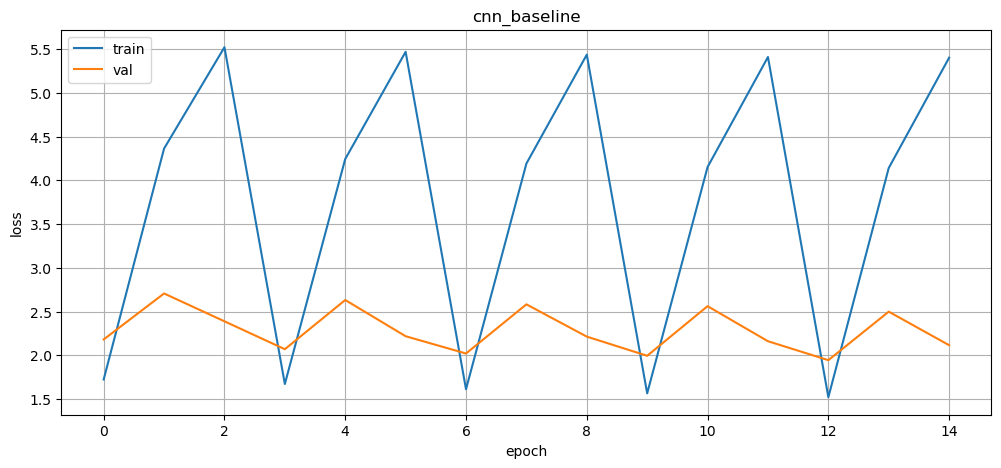

In [35]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [36]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [37]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/782 [00:00<?, ?it/s]

0.65775

In [38]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/79 [00:00<?, ?it/s]

0.0055

In [39]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_loss_train_micxut,█▅▃▁▁
epoch_loss_train_mixup,█▄▃▁▁
epoch_loss_train_reg,█▆▄▃▁
epoch_loss_val,▃█▅▂▇▄▂▇▃▁▇▃▁▆▃
mixcut_loss,▇▂▄▆▆▅█▃▂▅▃▅▁▂█▇▅▂▆█▅▂▂▃▁▃▄▃▂▅▄▅▅▄▄▅▄▄▅▃
mixup_loss,█▅▅▂▅▃▄▂█▃▄▃▃▂▃▃▅▅▃▂▂▄▁▃▃▁▂▃▁▃▂▁▂▄▃▄▃▂▁▃
reg_loss,▅▆▆▆▆▆▆▇▇▅█▅▄▅▃▃▆▃▅▃▄▂▃▁▄▄▁▃▃▃▅▃▃▃▆▃▅▂▂▅
epoch,14
epoch_loss_train_micxut,5.40217
epoch_loss_train_mixup,4.14163
